#**Performing Sentiment Analysis with Customer Review**

<p> We are taking the feedback data of the customers from our datawarehouse 
<b> (snowflake) </b> 
and we are performing sentiment analysis by using machine learning algorithms to classify negative,neutral and positive emotions of an customer.<br>
This machine learning model will help the client <b>Medico</b> to get the customer sentiments in realtime, which inturn will help the client to be more customer oriented and responsive.</p>

##**This notebook contains :-**

*   Connecting snowflake instance with python
*   Required modules for performing data analysis in python
*   Processing raw test to get useful meaning
*   Building sentiments to processed text
*   Visualization of different text processes
* Calculating polarity of text document.
*Performing stemming  and lemming of text doocument
* building different NLP sentiment analyzer
* Training and testing of different sentiment analyzer(ML model)
*Performing metrics analysis
* Plotting of ROC curve to visualize AUC(Area under curver)


# <h4> <b>Installing Snowflake Connector <b> </h4>

In [ ]:
!pip install snowflake-connector-python

In [ ]:
!pip install "snowflake-connector-python[pandas]"

In [ ]:
!pip install "snowflake-connector-python[secure-local-storage,pandas]"

In [ ]:
import snowflake.connector

In [ ]:
!pip install "snowflake-connector-python[pandas]"

# <h4> <b> Connecting to snowflake <b> </h4>

*   Connecting to snowflake
*   Getting data from snowflake



In [ ]:
# Gets the version
ctx = snowflake.connector.connect(
    user='SHAKSHAM',
    password='Kipi@100',
    account='lo95007.ap-south-1.aws',
    role= 'DATA_SCIENTIST',
    warehouse="DATA_SCIENCE_WH",
    database="DEVLOPMENT",
    schema="FEEDBACK",
    )
cs = ctx.cursor()

# Execute a statement that will generate a result set.
sql = ' select * from "DEVELOPMENT"."FEEDBACK"."FEEDBACK"'
# print(sql)
cs.execute(sql)

# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
df = cs.fetch_pandas_all()

**Summary :-** 

*   cs is a cursor which will execute the sql statement
*   The df variable contains all data that request



####**For testing purpose**

In [ ]:
#counting rows and columns in data frame
col=df.shape[1]
row=df.shape[0]
col_name=["REVIEWERID",
          "ASIN",
          "REVIEWERNAME",
          "HELPFUL",
          "REVIEWTEXT",
          "OVERALL",
          "SUMMARY",
          "REVIEWTIME"]
col_header=list(df)

# checking if the rows and columns imported are same as in snowflake 
if  row==10261 and col==8:
  flag=1
else:
  flag=0
if flag==1:
  print("Test Success")
else:
  print("Test failed")


Test Success


####**Summary :-** Showing test success means all rows and columns imported successfully.

####**Showing Imported Data**

In [ ]:
df.head()

REVIEWERID  ...   REVIEWTIME
0  A2IBPI20UZIR0U  ...  02 28, 2014
1  A14VAT5EAX3D9S  ...  03 16, 2013
2  A195EZSQDW3E21  ...  08 28, 2013
3  A2C00NNG1ZQQG2  ...  02 14, 2014
4   A94QU4C90B1AX  ...  02 21, 2014

[5 rows x 8 columns]

#### **Summary:-** Showing resultant data

#**Importing Libraries**

*   **Pandas :-** Pandas is an open source Python package that is most widely used for data science/data analysis and machine learning tasks
*   **NumPy :-** NumPy is a general-purpose array-processing package. It provides a high-performance multidimensional array object, and tools for working with these arrays.
*   **NLTK :-** The Natural Language Toolkit, is a suite of libraries and programs for symbolic and statistical natural language processing (NLP) for English written in the Python programming language
*   **Sklearn :-** Scikit-learn is the most useful and robust library for machine learning in Python. It provides a selection of efficient tools for machine learning and statistical modeling including classification, regression etc.
*    **Matplotlib :-** Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python


In [ ]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
# from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

# <h2> <b> Sentiment Analysis <b> </h2>

In [ ]:
#Creating a copy
process_reviews=df.copy()

#Checking for null values
process_reviews.isnull().sum()

REVIEWERID       0
ASIN             0
REVIEWERNAME    27
HELPFUL          0
REVIEWTEXT       7
OVERALL          0
SUMMARY          0
REVIEWTIME       0
dtype: int64

####**Summary :-** Creating a copy and checking for null values

In [ ]:
process_reviews['REVIEWTEXT']=process_reviews['REVIEWTEXT'].fillna('Missing')

In [ ]:
process_reviews['REVIEWS']=process_reviews['REVIEWTEXT']+process_reviews['SUMMARY']
process_reviews=process_reviews.drop(['REVIEWTEXT', 'SUMMARY'], axis=1)
process_reviews.head()

REVIEWERID  ...                                            REVIEWS
0  A2IBPI20UZIR0U  ...  Not much to write about here, but it does exac...
1  A14VAT5EAX3D9S  ...  The product does exactly as it should and is q...
2  A195EZSQDW3E21  ...  The primary job of this device is to block the...
3  A2C00NNG1ZQQG2  ...  Nice windscreen protects my MXL mic and preven...
4   A94QU4C90B1AX  ...  This pop filter is great. It looks and perform...

[5 rows x 7 columns]

In [ ]:
#Figuring out the distribution of categories
process_reviews['OVERALL'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: OVERALL, dtype: int64

####**This function returns sentiment value based on the overall ratings from the user**

In [ ]:
def f(row):
    if row['OVERALL'] == 3.0:
        val = 'Neutral'
    elif row['OVERALL'] == 1.0 or row['OVERALL'] == 2.0:
        val = 'Negative'
    elif row['OVERALL'] == 4.0 or row['OVERALL'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

####**Applying the function in our new column**

In [ ]:
process_reviews['SENTIMENT'] = process_reviews.apply(f, axis=1)
process_reviews.head()

REVIEWERID  ... SENTIMENT
0  A2IBPI20UZIR0U  ...  Positive
1  A14VAT5EAX3D9S  ...  Positive
2  A195EZSQDW3E21  ...  Positive
3  A2C00NNG1ZQQG2  ...  Positive
4   A94QU4C90B1AX  ...  Positive

[5 rows x 8 columns]

####**Summary :-** 

<h4> <b> Spilitting columns <b> </h4>

In [ ]:
# new data frame which has date and year
new = process_reviews["REVIEWTIME"].str.split(",", n = 1, expand = True)
  
# making separate date column from new data frame 
process_reviews["DATE"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["YEAR"]= new[1] 

process_reviews=process_reviews.drop(['REVIEWTIME'], axis=1)
process_reviews.head()


REVIEWERID        ASIN  ...   DATE   YEAR
0  A2IBPI20UZIR0U  1384719342  ...  02 28   2014
1  A14VAT5EAX3D9S  1384719342  ...  03 16   2013
2  A195EZSQDW3E21  1384719342  ...  08 28   2013
3  A2C00NNG1ZQQG2  1384719342  ...  02 14   2014
4   A94QU4C90B1AX  1384719342  ...  02 21   2014

[5 rows x 9 columns]

####**Summary:-**

*   Separate Date column for new data frame
*   Separate Year column for new data frame



In [ ]:
# Splitting the date 
new1 = process_reviews["DATE"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["MONTH"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["DAY"]= new1[1] 

process_reviews=process_reviews.drop(['DATE'], axis=1)
process_reviews.head()

REVIEWERID        ASIN  ... MONTH DAY
0  A2IBPI20UZIR0U  1384719342  ...    02  28
1  A14VAT5EAX3D9S  1384719342  ...    03  16
2  A195EZSQDW3E21  1384719342  ...    08  28
3  A2C00NNG1ZQQG2  1384719342  ...    02  14
4   A94QU4C90B1AX  1384719342  ...    02  21

[5 rows x 10 columns]

####**Summary :-** Separate Columns for year,month and day

####**Performing transformation on some columns**

In [ ]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["HELPFUL"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)
#print(new1,new2,new3)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)

# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['RESULT'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['RESULT']=0

#Filling the NaN values(created due to dividing) with 0
helpful['RESULT'] = helpful['RESULT'].fillna(0)

#Rounding of the results to two decimal places
helpful['RESULT']=helpful['RESULT'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['HELPFUL_RATE']=helpful['RESULT']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['HELPFUL'], axis=1)

In [ ]:
process_reviews.head()

REVIEWERID        ASIN  ... DAY  HELPFUL_RATE
0  A2IBPI20UZIR0U  1384719342  ...  28          0.00
1  A14VAT5EAX3D9S  1384719342  ...  16          0.93
2  A195EZSQDW3E21  1384719342  ...  28          1.00
3  A2C00NNG1ZQQG2  1384719342  ...  14          0.00
4   A94QU4C90B1AX  1384719342  ...  21          0.00

[5 rows x 10 columns]

####**Summary :-**

*   Splitting the dataset based on comma and dropping empty columns.
*   Concatenating the splitted columns
*   Trim whitespace from ends of each value across all series in dataframe
*   Rounding off results and filling Nan with 0.







##**Filtering Data**

In [ ]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['REVIEWERNAME'], axis=1)

#Creating a copy 
clean_reviews=process_reviews.copy()

####**Function to remove impurities in data**

In [ ]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
process_reviews['REVIEWS']=process_reviews['REVIEWS'].apply(lambda x:review_cleaning(x))
process_reviews.head()

REVIEWERID        ASIN  OVERALL  ... MONTH DAY HELPFUL_RATE
0  A2IBPI20UZIR0U  1384719342      5.0  ...    02  28         0.00
1  A14VAT5EAX3D9S  1384719342      5.0  ...    03  16         0.93
2  A195EZSQDW3E21  1384719342      5.0  ...    08  28         1.00
3  A2C00NNG1ZQQG2  1384719342      5.0  ...    02  14         0.00
4   A94QU4C90B1AX  1384719342      5.0  ...    02  21         0.00

[5 rows x 9 columns]

####**Summary:-** Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.

In [ ]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [ ]:
process_reviews['REVIEWS'] = process_reviews['REVIEWS'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

REVIEWERID        ASIN  OVERALL  ... MONTH DAY HELPFUL_RATE
0  A2IBPI20UZIR0U  1384719342      5.0  ...    02  28         0.00
1  A14VAT5EAX3D9S  1384719342      5.0  ...    03  16         0.93
2  A195EZSQDW3E21  1384719342      5.0  ...    08  28         1.00
3  A2C00NNG1ZQQG2  1384719342      5.0  ...    02  14         0.00
4   A94QU4C90B1AX  1384719342      5.0  ...    02  21         0.00

[5 rows x 9 columns]

####**Summary :-** Removing stop words from the sentence

####**Calculating mean of Helpul_Rate**

In [ ]:
pd.DataFrame(process_reviews.groupby('SENTIMENT')['HELPFUL_RATE'].mean())

HELPFUL_RATE
SENTIMENT              
Negative       0.227495
Neutral        0.233238
Positive       0.226090

####**Summary :-** Show the helpful rate of negative,neutral and positive reviews.

<h4><b> Plotting Graph <b></h4>

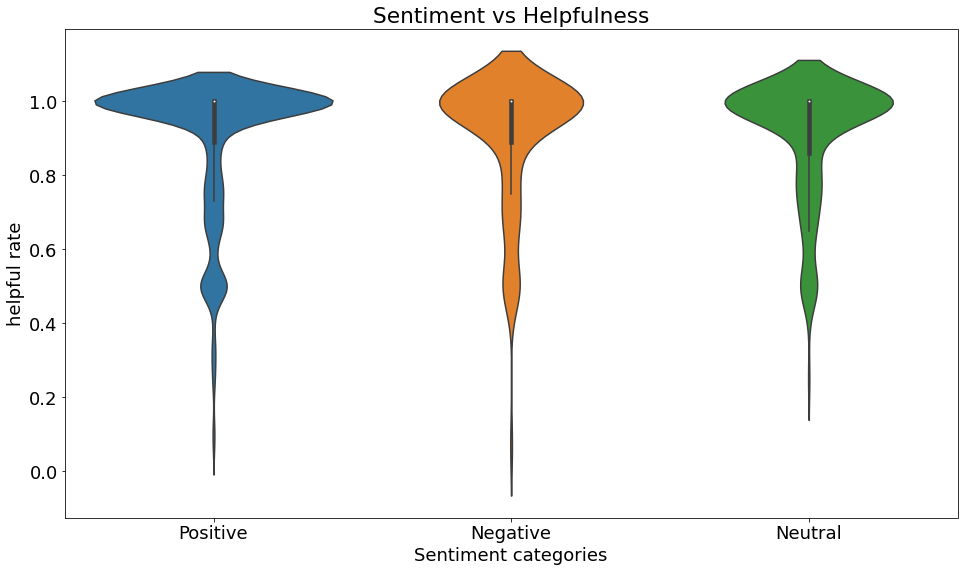

In [ ]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['SENTIMENT', 'HELPFUL_RATE'])
senti_help = senti_help[senti_help['HELPFUL_RATE'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["SENTIMENT"], y=senti_help["HELPFUL_RATE"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

####**Summary :-** Plotting violin graph which shows density of positive , negative and neutral emotion
<p> We are analyzing sentiments of the customer reviews in which most of reviews are positive followed by neutral sentiments and negative reviews are minimum.
 </p>


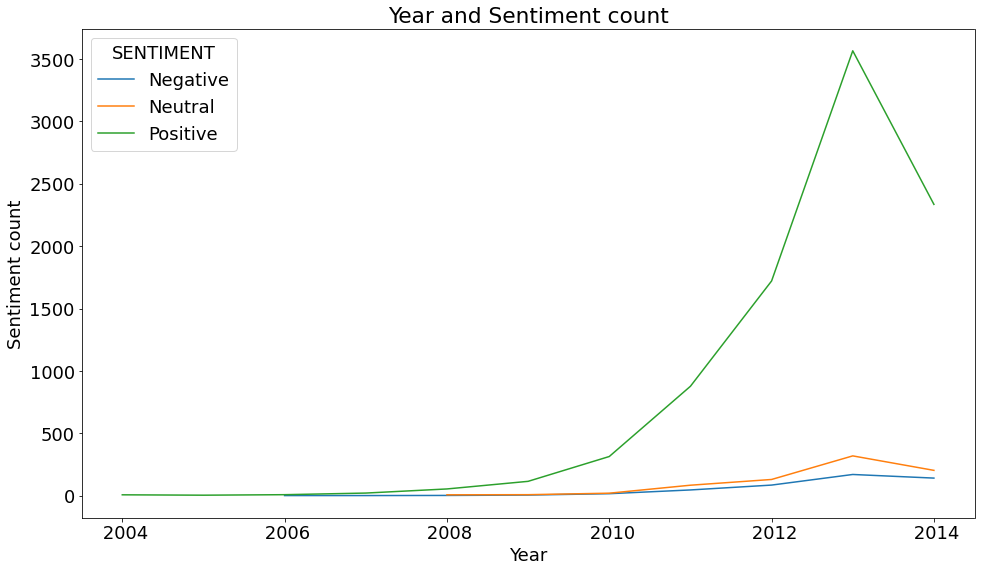

In [ ]:
process_reviews.groupby(['YEAR','SENTIMENT'])['SENTIMENT'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

####**Summary:-** Showing line graph of sentiment count vs year


*   Positive sentiment count is maximum among all and highest in 2012-2014.
*   Negative sentiment is minimum and high between 2012-2014.
*   Neutral is highest between 2012-2014,



####**Plotting bar graph of Day vs Reviews Count**

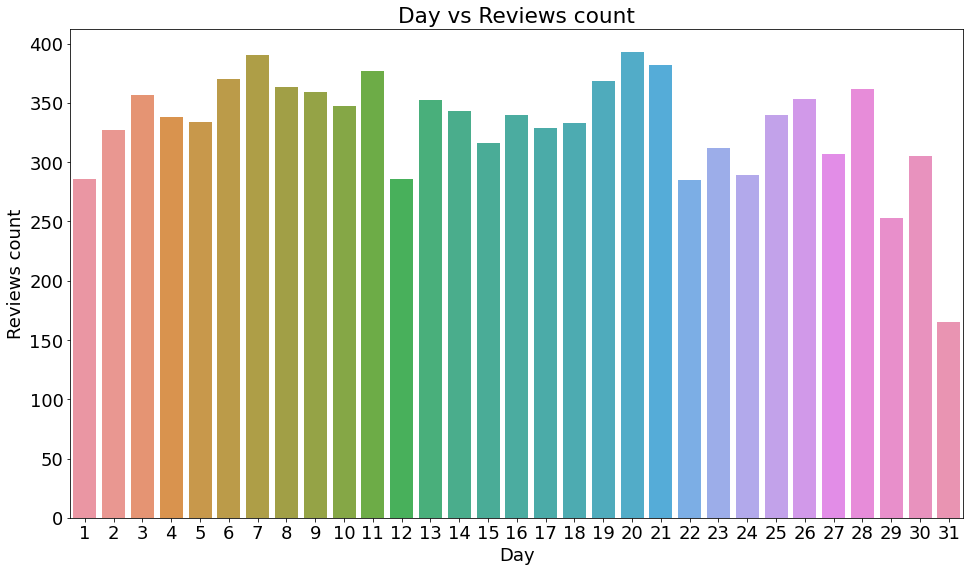

In [ ]:
day=pd.DataFrame(process_reviews.groupby('DAY')['REVIEWS'].count()).reset_index()
day['DAY']=day['DAY'].astype('int64')
day.sort_values(by=['DAY'])

#Plotting the graph
sns.barplot(x="DAY", y="REVIEWS", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

####**Summary:-**Showing reviewes count received by client on everyday in which maximum reviews counted on day 20 and minimum on day 31.

In [ ]:
process_reviews['POLARITY'] = process_reviews['REVIEWS'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['REVIEW_LEN'] = process_reviews['REVIEWS'].astype(str).apply(len)
process_reviews['WORD_COUNT'] = process_reviews['REVIEWS'].apply(lambda x: len(str(x).split()))

In [ ]:
process_reviews.head()

REVIEWERID        ASIN  OVERALL  ...  POLARITY REVIEW_LEN WORD_COUNT
0  A2IBPI20UZIR0U  1384719342      5.0  ...  0.250000        162         25
1  A14VAT5EAX3D9S  1384719342      5.0  ...  0.014286        356         55
2  A195EZSQDW3E21  1384719342      5.0  ...  0.167500        315         48
3  A2C00NNG1ZQQG2  1384719342      5.0  ...  0.333333        169         22
4   A94QU4C90B1AX  1384719342      5.0  ...  0.800000        136         21

[5 rows x 12 columns]

In [ ]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
process_reviews['POLARITY'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

In [ ]:
process_reviews['OVERALL'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',

    
    title='Review Rating Distribution')

# <h1> <b> Word Cloud <b> </h1>

####**Installing word cloud**

In [ ]:
pip install wordcloud

<h4> <b> Filtering data and showing wordcloud<b> </h4>

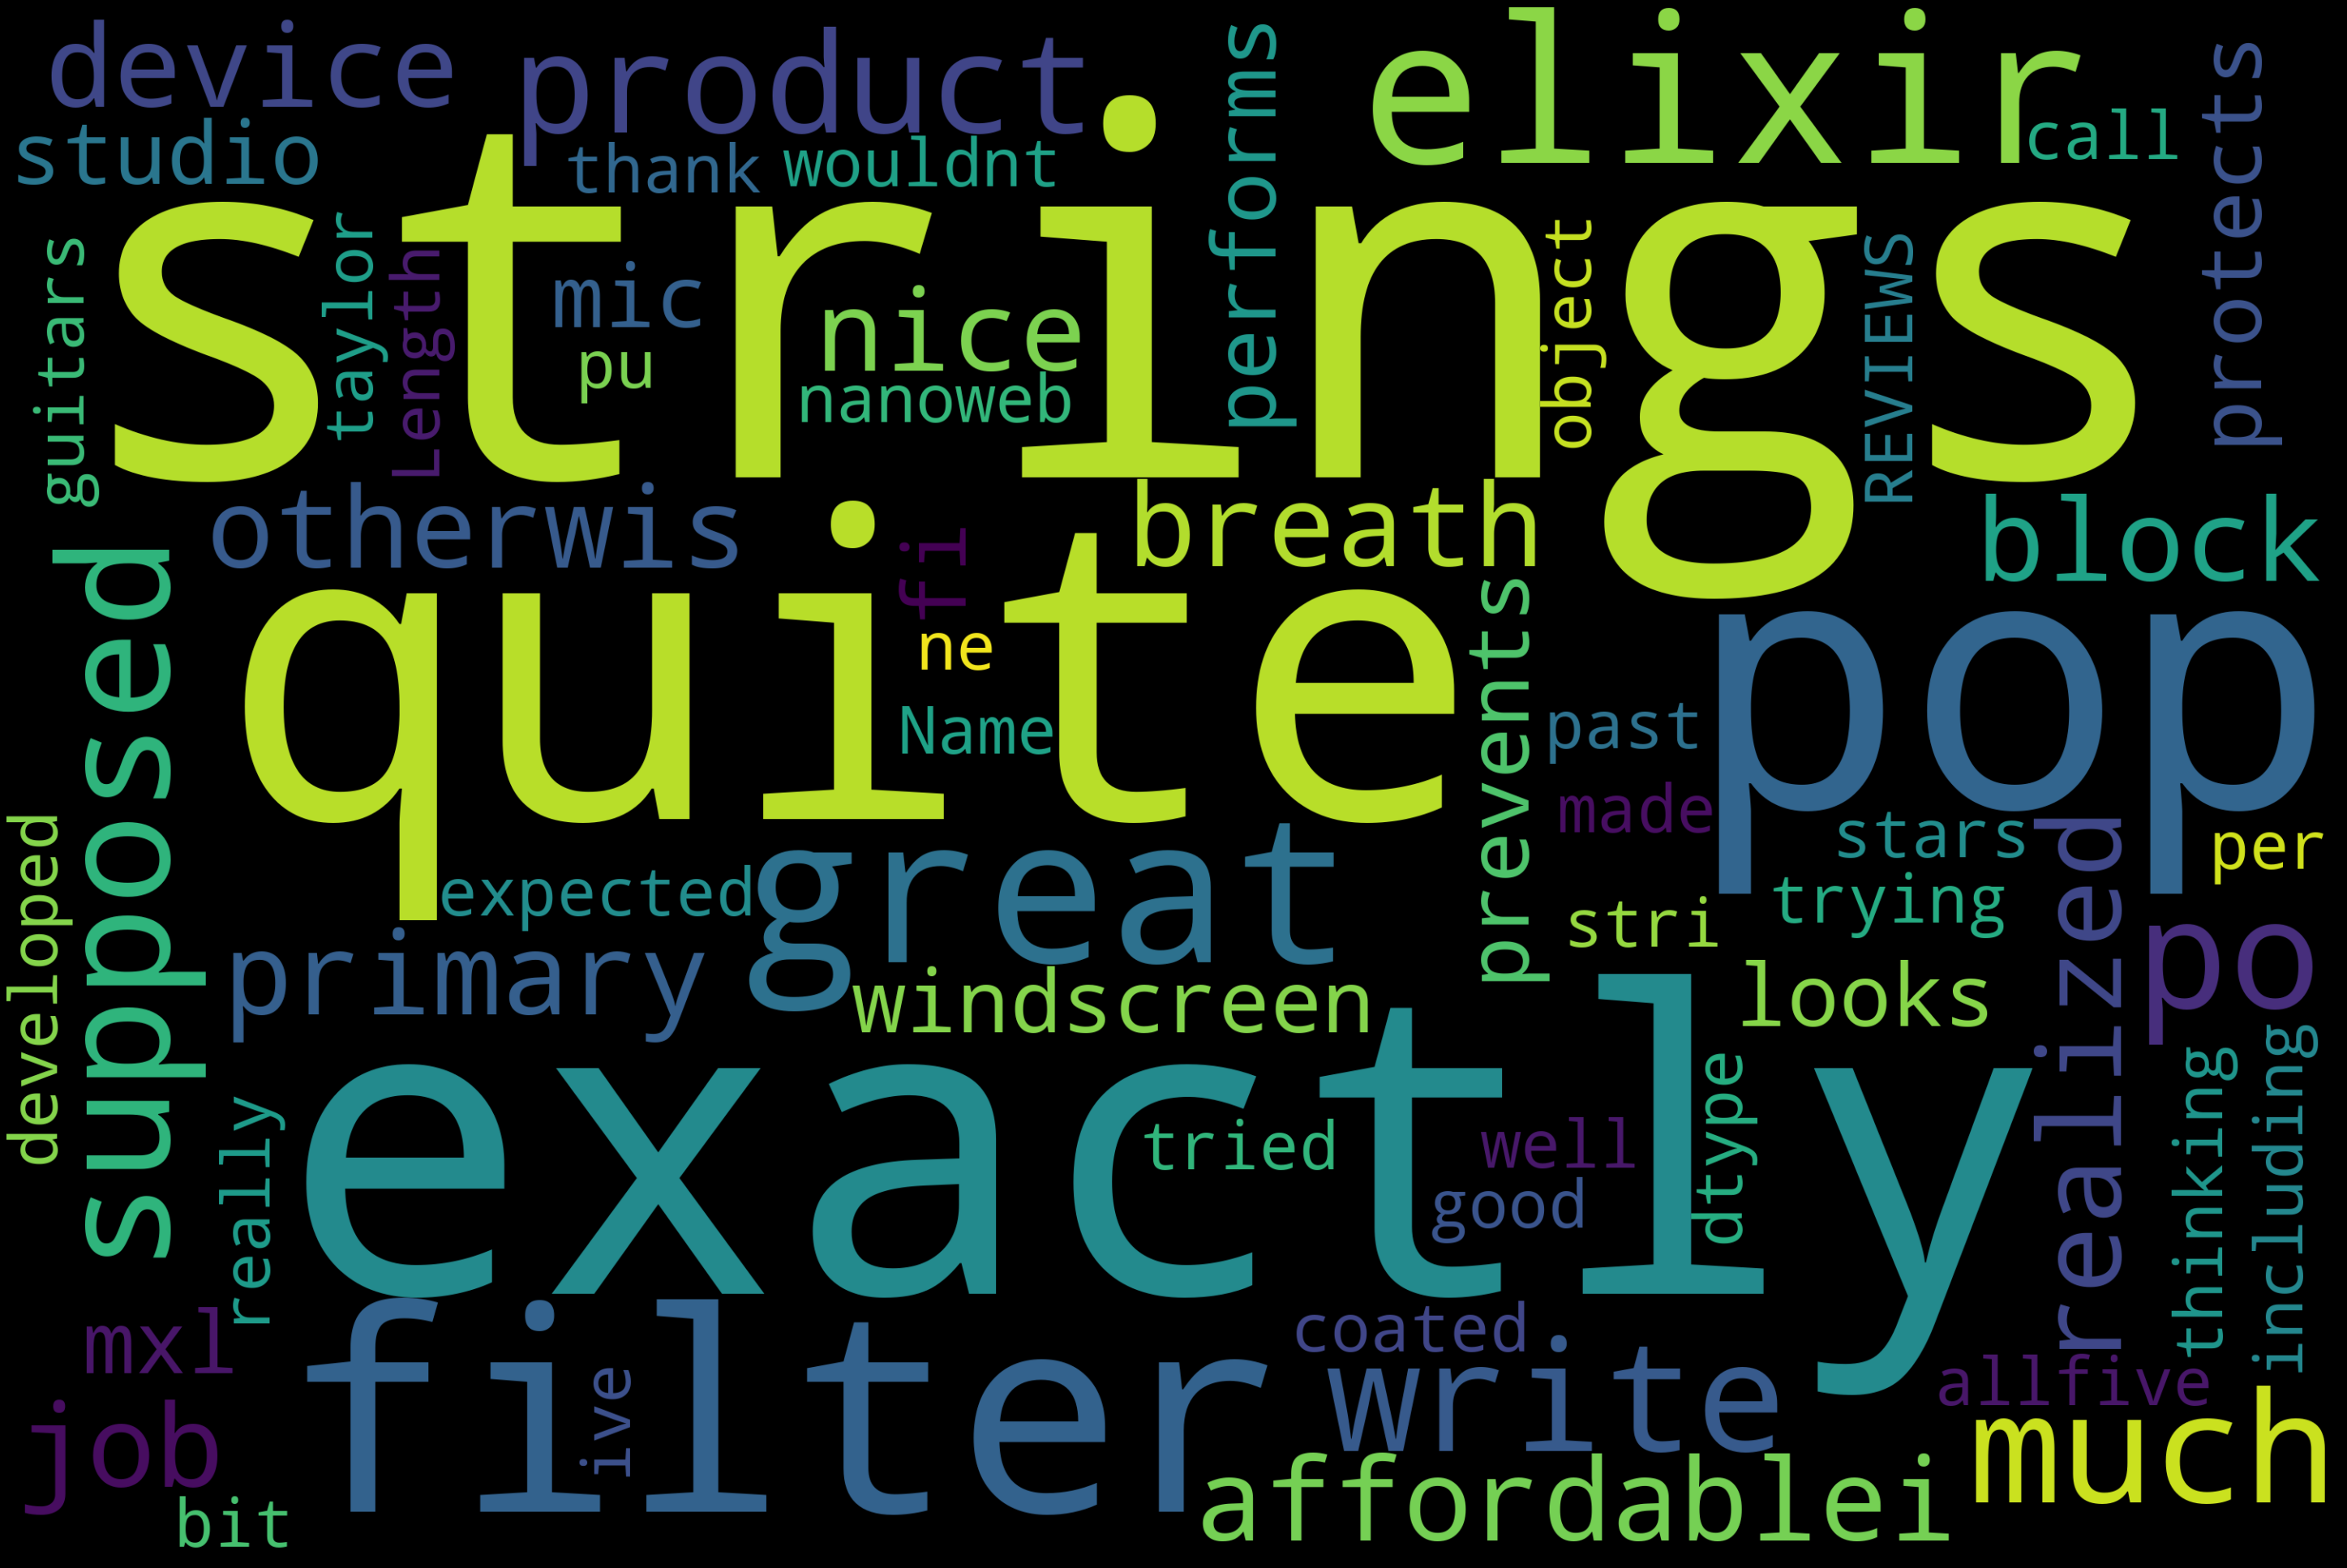

In [ ]:
from wordcloud import WordCloud,STOPWORDS
review_pos = process_reviews[process_reviews["SENTIMENT"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["SENTIMENT"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["SENTIMENT"]=='Negative'].dropna()
text = review_pos["REVIEWS"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

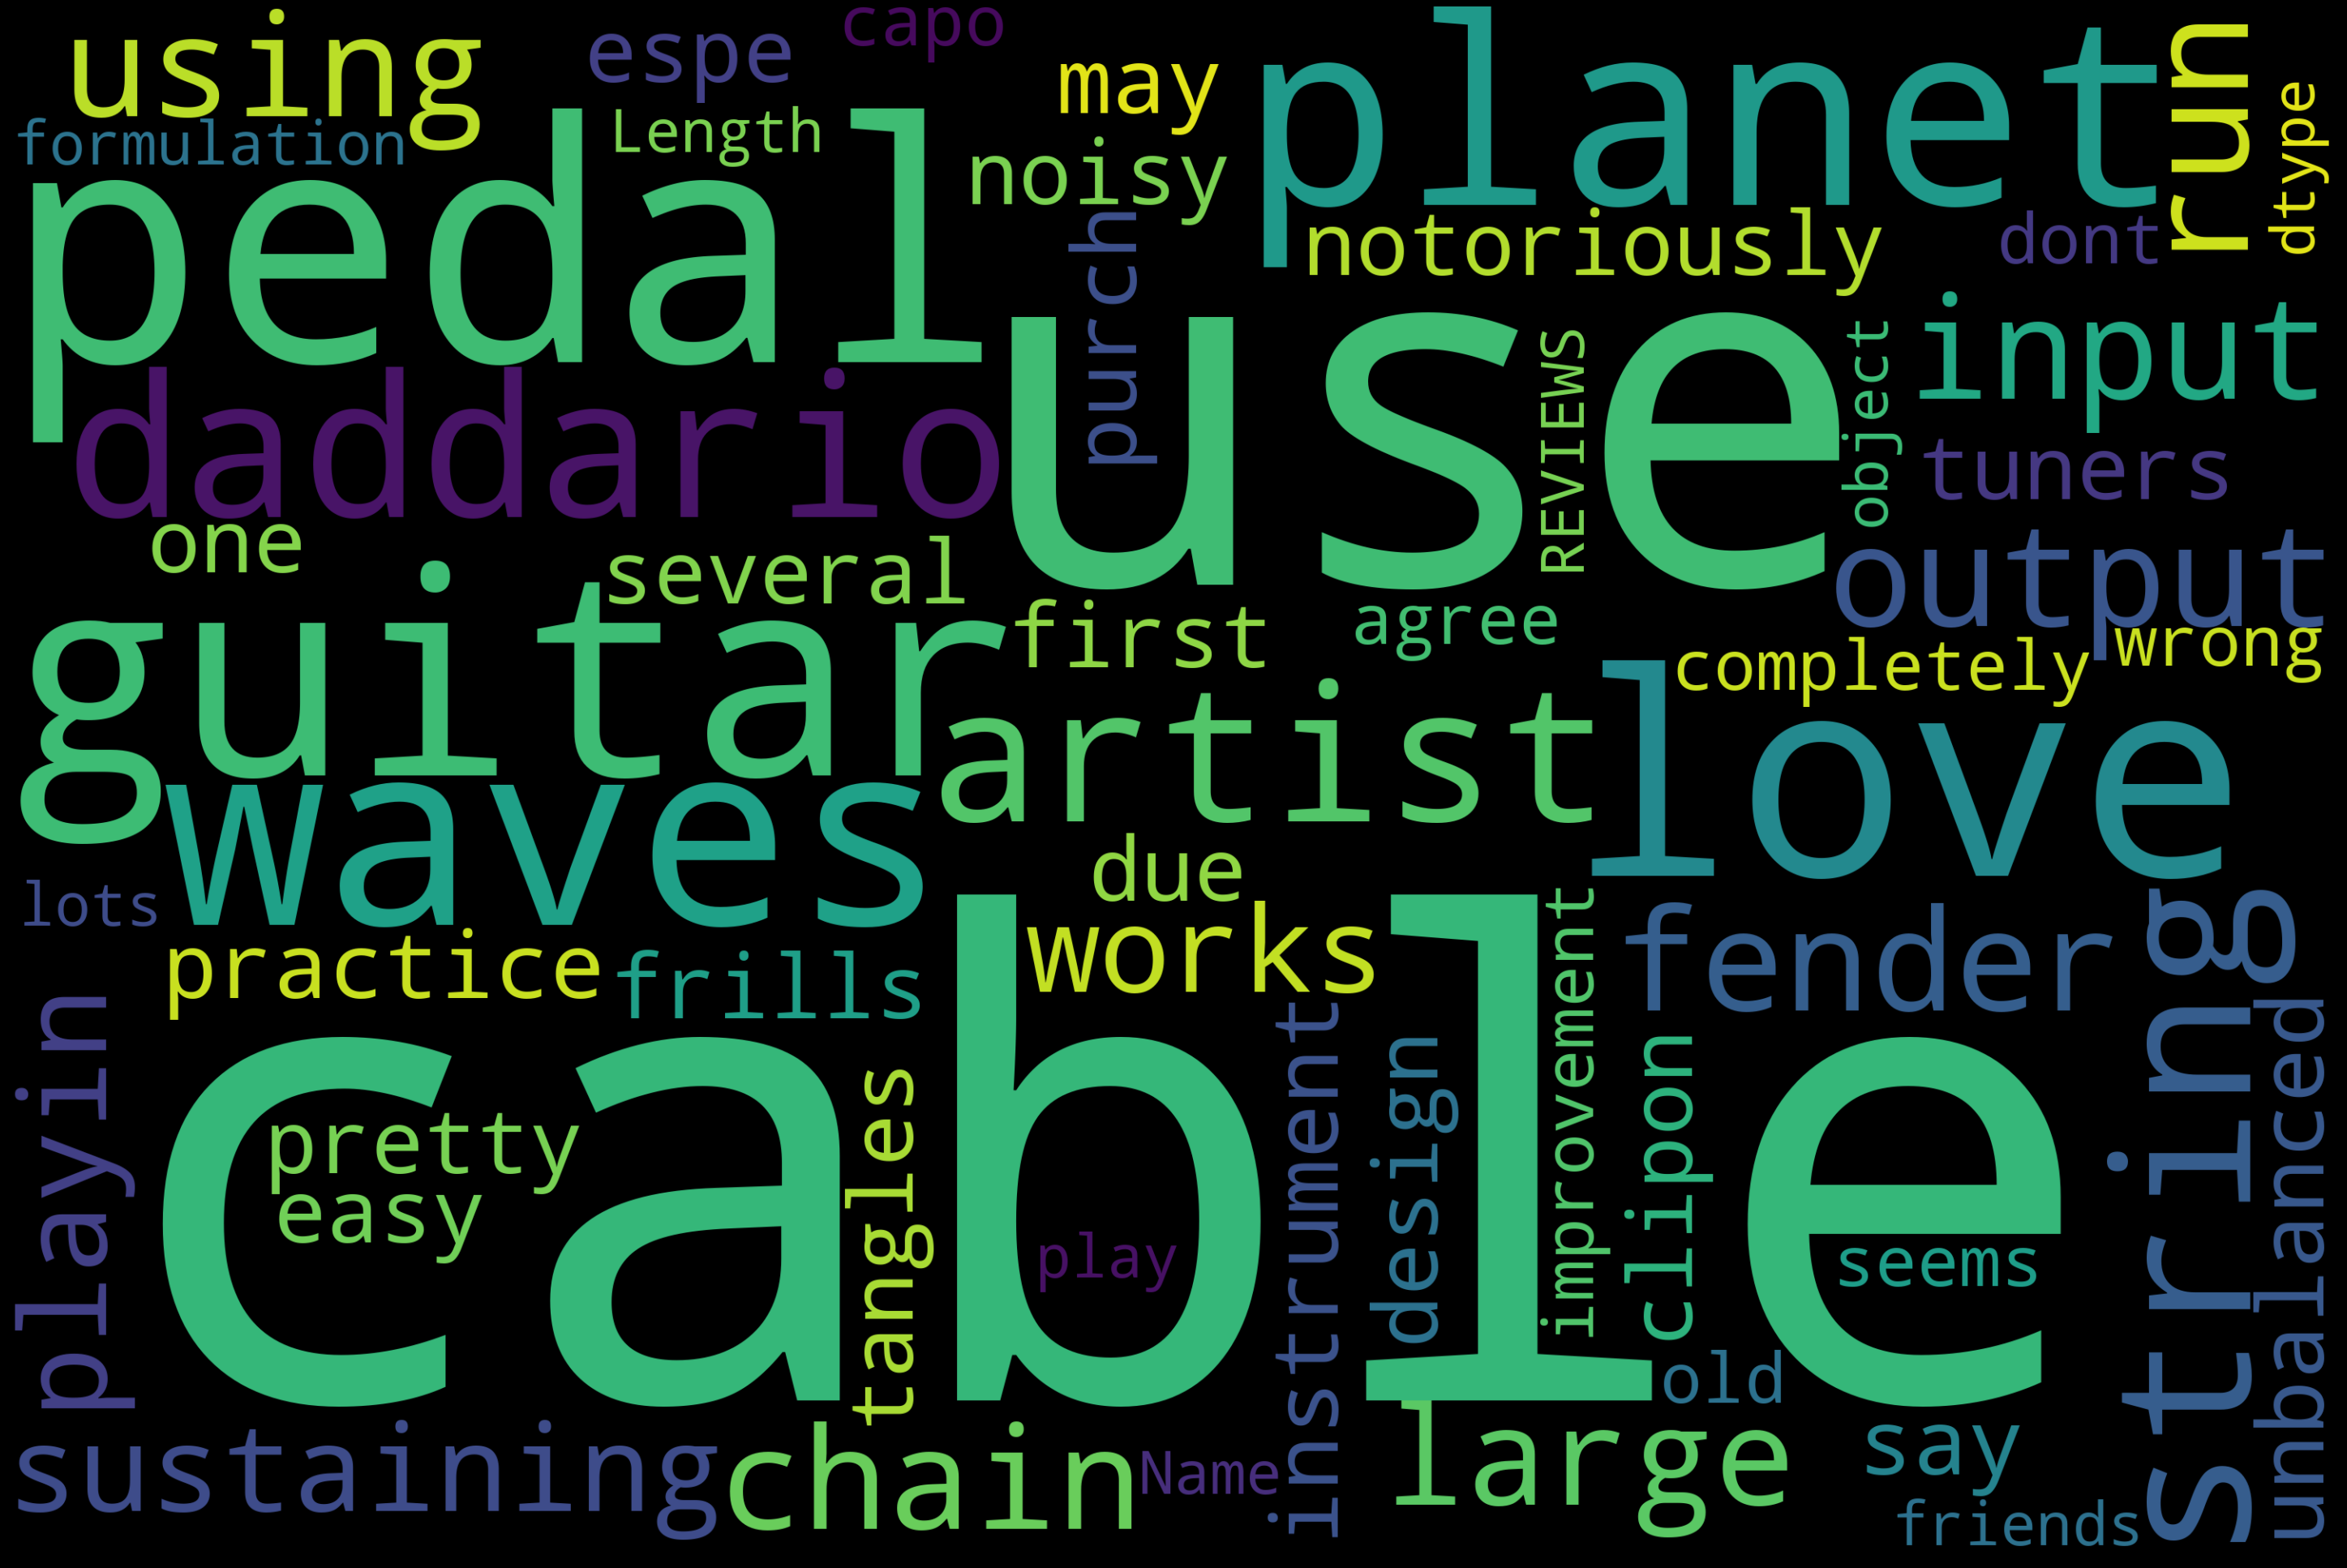

In [ ]:
text = review_neu["REVIEWS"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

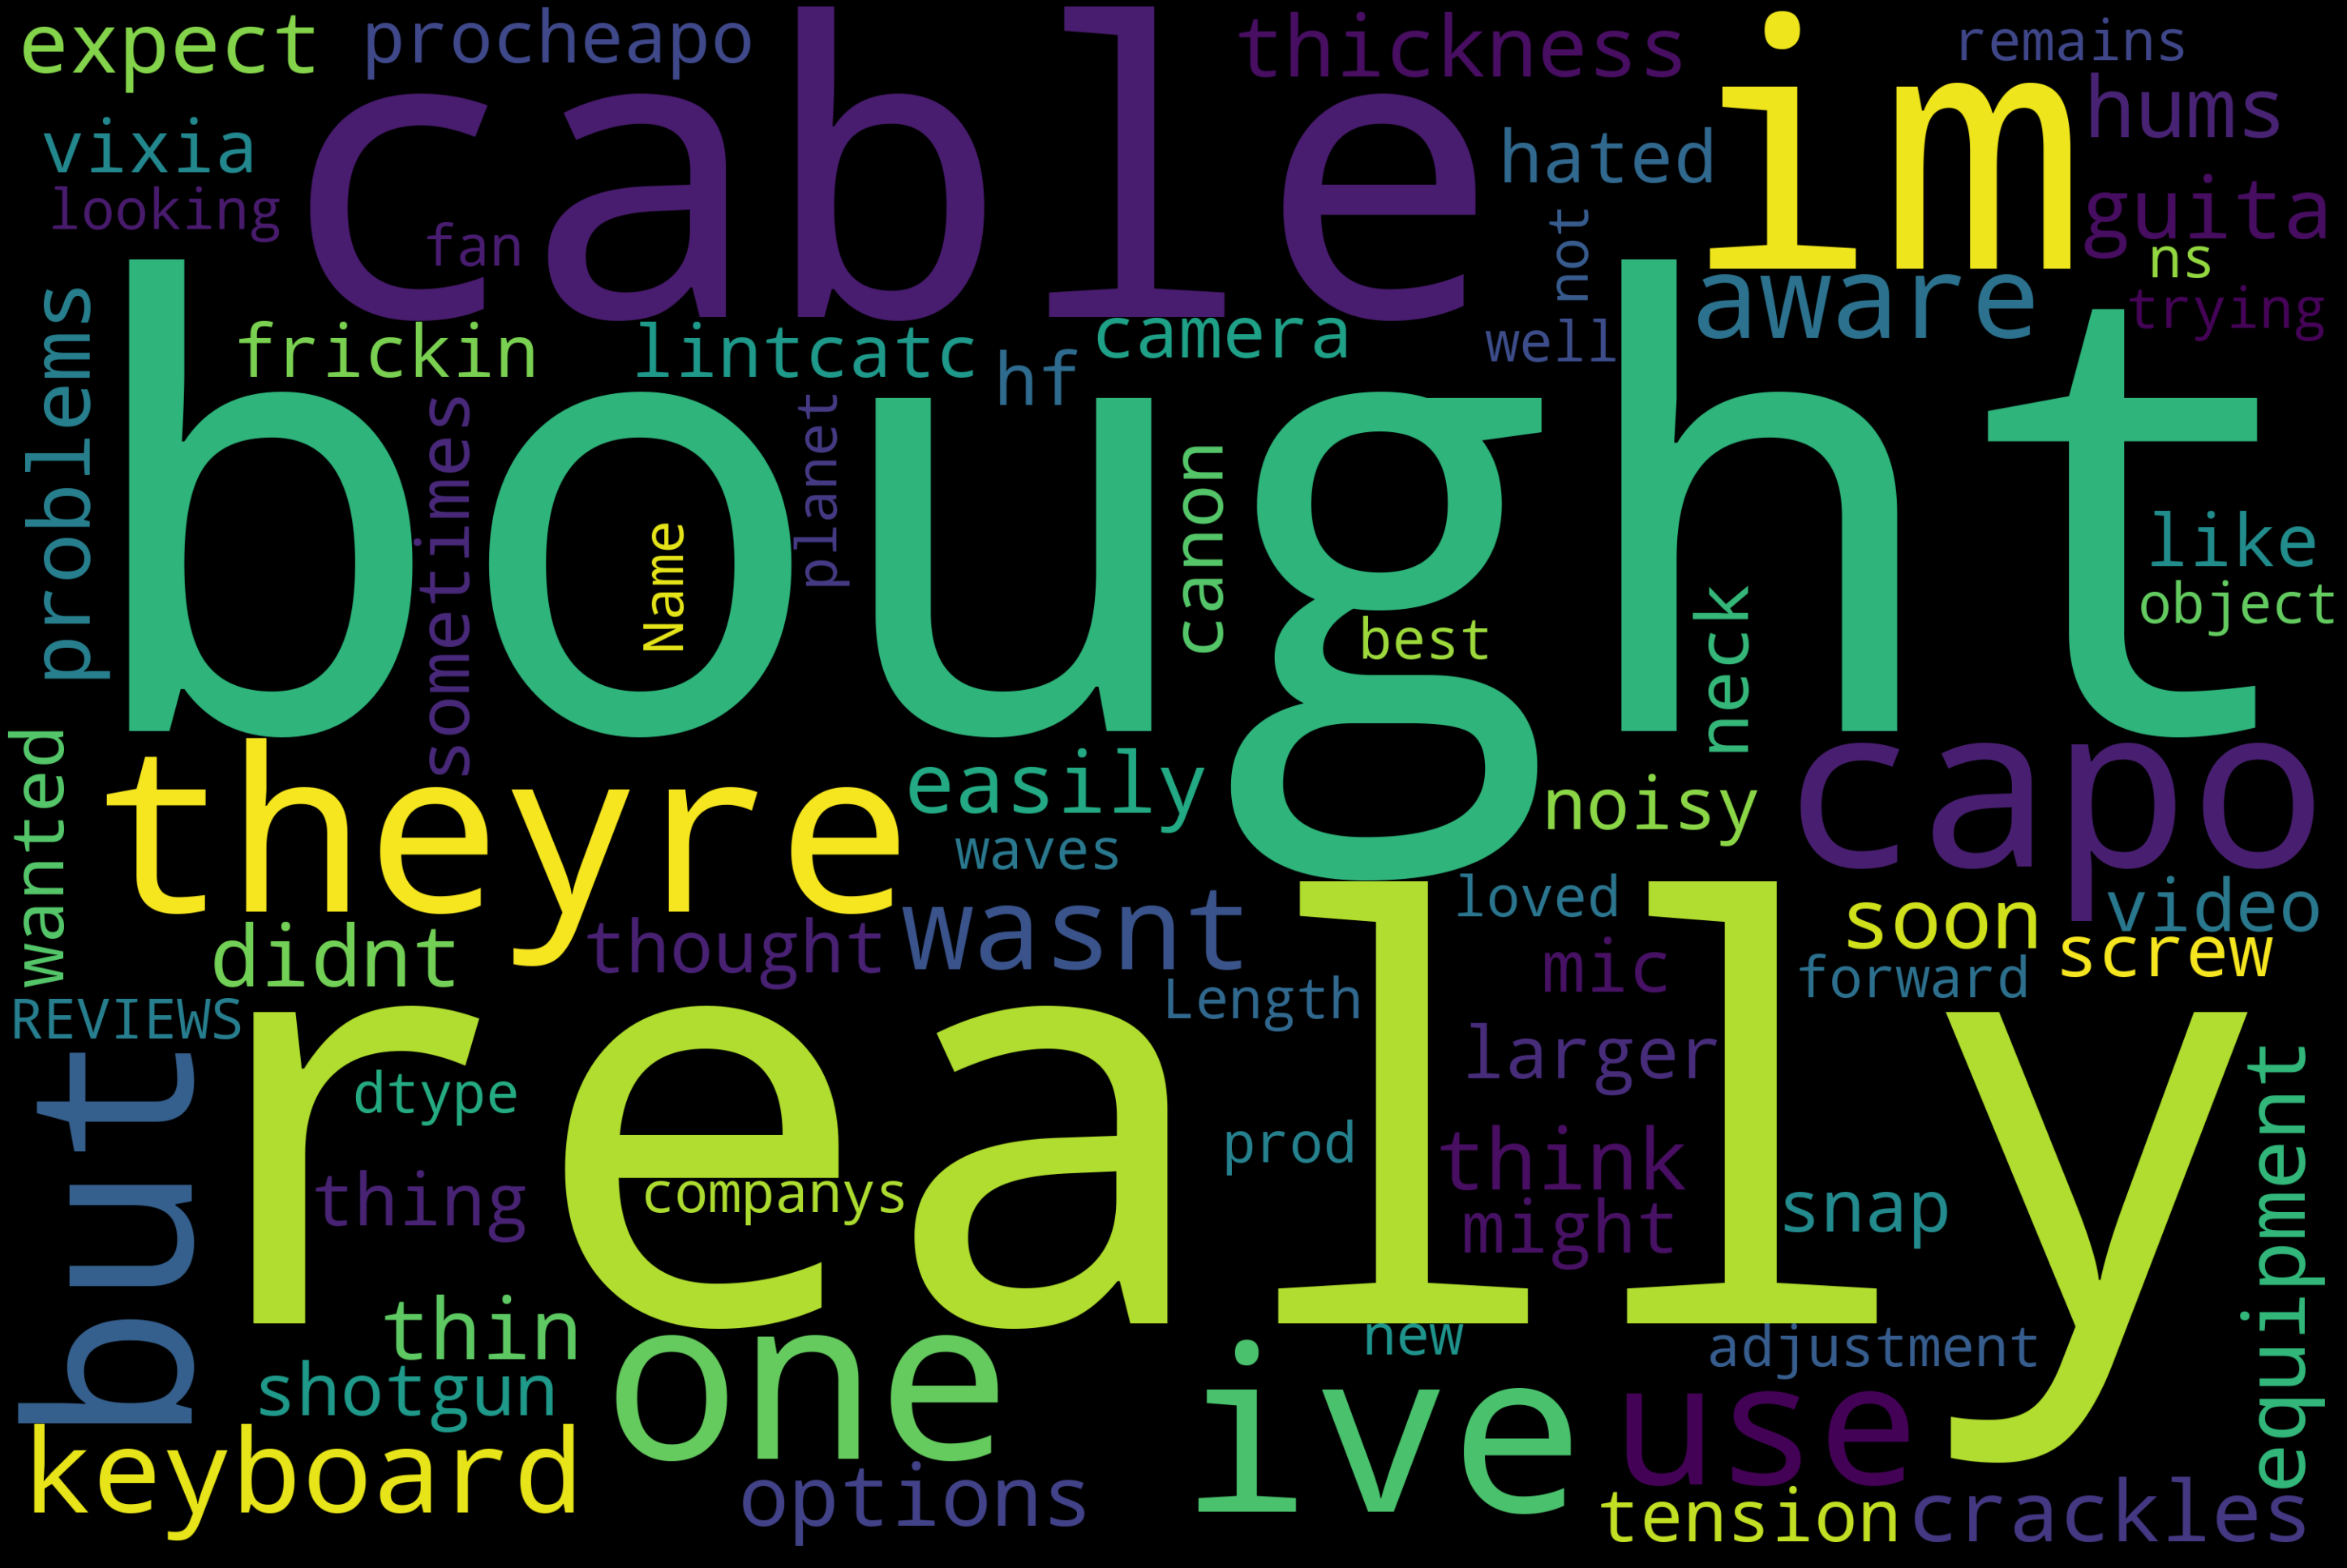

In [ ]:
text = review_neg["REVIEWS"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<h4><b>Encode labels in column 'sentiment' <b> </h4>

In [ ]:
label_encoder = preprocessing.LabelEncoder() 
  
 
process_reviews['SENTIMENT']= label_encoder.fit_transform(process_reviews['SENTIMENT']) 
  
process_reviews['SENTIMENT'].unique() 

array([2, 1, 0])

####**Summary :-** Here 2 shows the positive sentiment , 1 shows the neutral sentiment and 0 shows the negative sentiment.

<h4> <b> Extracting 'reviews' for processing <b> </h4>

In [ ]:

review_features=process_reviews.copy()
review_features=review_features[['REVIEWS']].reset_index(drop=True)
review_features.head()

REVIEWS
0  not much write but exactly supposed filters po...
1  product exactly quite affordablei not realized...
2  primary job device block breath would otherwis...
3  nice windscreen protects mxl mic prevents pops...
4  pop filter great looks performs like studio fi...

####**Summary :-** Processed data with no inflection

####**Performing stemming on the review dataframe**

In [ ]:
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['REVIEWS'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review) 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['REVIEWS'])

####**Summary:-** Making "Term Frequency — Inverse Document Frequency" in which measures the frequency of a word in a document.

In [ ]:
y=process_reviews['SENTIMENT']

In [ ]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

####**Summary :-** I creates new samples from the existing ones called resampled data.

####**Divide the dataset into Train and Test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)


####**Summary :-** Splitting the dataset for training and testing purpose in 3:1

#### **Prints and plot the confusion matrix.**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

####**Summary :-** We are showing five models for testing with thier accuracy

In [ ]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

####**Summary :-** We perform the grid search on LogisticRegression have highest frequency

In [ ]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

####**Summary :-** Showing a tabular summary of the number of correct and incorrect predictions made by a classifier of positive,neutral and negative sentiments.

In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

####**Summary :-** Showing performance metrics to give best results

*   Maximizing precision will minimize the number of false positives
*   Maximizing the recall will minimize the number of false negatives



####**Plotting all ROC curves**

In [ ]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

####**Summary :-** micro-average ROC curve is best because it have maximumn area under curve i.e 0.95